## Project Proposal: US Citizens Annual Income in the 1994s

### Introduction

During much of the 1990s, the United States was subject to the largest economic expansion it had seen since the 1960s. A huge technological boom brought a 3% economic growth rate, two million new jobs, and a stable 2.1% inflation rate following a minor recession in 1990. With record low unemployment rates and the need for highly educated, fast-learning employees to keep up with other countries technological advances, the United States saw an increase in income rates in 1994 compared to previous years. Wage inequality was still prominent for many minorities in the workforce like women, immigrants, and people of colour, requiring the need for working long hours with lesser pay. 

An analysis of the 1994 census data will allow us to predict whether a given person's income is greater or lesser than/equal to $50,000 based on factors like age, level of education, sex, race, and hours worked per week. Understanding the data in this way will allow for comparisons to be made to current incomes of US residents 30 years later to analyze changes in wage disparity experienced by the described individuals. 

We will be using the **Adult** dataset taken from https://archive.ics.uci.edu/dataset/2/adult, which has extracted 32,560 entries from the 1994 US census. Of the 32,560 rows, each observation represents a single person and their various attributes. There are 15 columns each signifying a different defining factor. The columns are:

 - age: age of individual (integar >0)
 - workclass: employment status (ex. self-employed, private, unemployed)
 - fnlwgt: final weight or the number of people this individual's entry represents (integar >0)
 - education: the highest level of education completed (ex. 12th grade, Bachelor's, Doctorate)
 - education-num: the highest level of education completed in numerical form (integar >0)
 - marital-status: marital status (ex. married, single)
 - occupation: general type of occupation held (ex. sales, services, etc.)
 - relationship: primary relationship to others (ex. wife, husband, relative)
 - race: racial indetity (ex. white, black, asian)
 - sex: biological sex (ex. male, female)
 - capital-gain: money gained on investments (integar >0)
 - capital-loss: money lost on investments (integar >0)
 - hours-per-week: hours at work each week
 - native-country: country of origin (ex. United States, India, Cuba)
 - income: annual income (integar <=50k, >50k)

### Preliminary Data Analysis

In [3]:
# Loading libraries
library(tidyverse)
library(repr)
library(tidymodels)

In [4]:
# Reading downloaded csv file
adult <- read_csv("data/adult.csv")

# Adding column names
colnames(adult) <- c('age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                     'marital_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income')
slice(adult, 1:4)

Rows: 32560 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): State-gov, Bachelors, Never-married, Adm-clerical, Not-in-family, W...
dbl (6): 39, 77516, 13, 2174, 0, 40

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Many of the predictors are categorical so we need to convert them into numerical values
adult_numerical <- adult |>
    select(workclass, education, marital_status, occupation, relationship, race, sex, native_country) |>
    mutate(across(workclass:native_country, as.factor)) |>
    sapply(unclass) 
adult_final <- adult |>
    select(age, fnlwgt, education_num, capital_gain, capital_loss, hours_per_week, income)
adult_final <- cbind(adult_final, adult_numerical) |>
    mutate(income = as_factor(income))

# Getting the training data
set.seed(3456) 

# Randomly take 75% of the data in the training set. 
adult_split <- initial_split(adult_final, prop = 0.75, strata = income)  
adult_train <- training(adult_split)   
adult_test <- testing(adult_split)

In [6]:
# Beginning data analysis:
# We will take the mean of our numerical predictors and the mode of our categorical predictors

analysis_mean <- adult_train |>
    select(age, fnlwgt, capital_gain, capital_loss, hours_per_week) |>
    map_df(mean, na.rm = TRUE)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

analysis_mode <- adult |>
    select(workclass, education, marital_status, occupation, relationship, race, sex, native_country) |>
    map_df(getmode)

# Mean value of our numerical predictors
analysis_mean
# Most frequent value of our categorical predictors 
analysis_mode

age,fnlwgt,capital_gain,capital_loss,hours_per_week
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
38.60363,189183.4,1136.137,88.29805,40.44252


workclass,education,marital_status,occupation,relationship,race,sex,native_country
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States


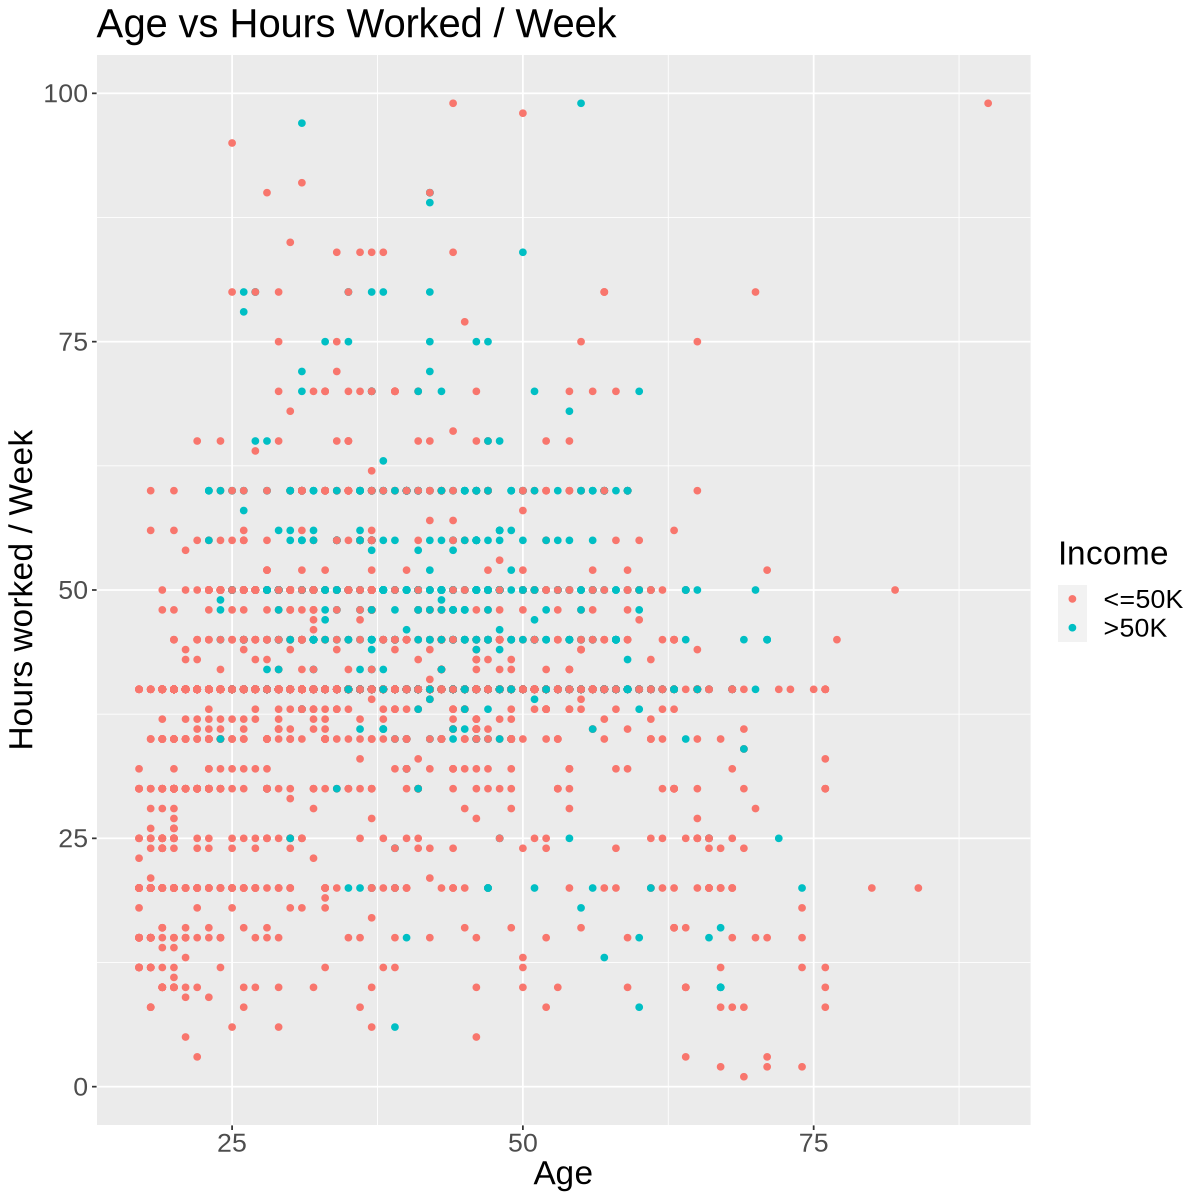

In [26]:
# Scatter plot of Age vs Hours Per Week
options(repr.plot.width=10, repr.plot.height=10)

# Currently there is too much data so we want to take a small sample
# to improve the visualization
filtered_adult <- adult_train |>
    sample_n(2500) 

# Generate plot of Age vs Hours with Coloured Income
age_vs_hrs <- filtered_adult |>
    ggplot(aes(x = age, y = hours_per_week)) +
    geom_point(aes(colour = income)) +
    labs(x = "Age", y = "Hours worked / Week", colour = "Income") +
    ggtitle("Age vs Hours Worked / Week") +
    theme(text = element_text(size = 20))

age_vs_hrs

### Methods

Our question is a classification problem so we want to use the K nearest neighbors model in tidymodels. Since we converted all columns to numerical we can use any column as a predictor. We want to use the majority of the columns available as predictors because most of them are fairly relevant to income. But there are some variables that we don't want to use or make some changes to:
1. The relationship and marital_status columns are redundant so we can just use marital_status.
2. Workclass is not very relevant to income so we will not use it as a predictor.
3. Marital status contains information on whether they are married to a civilian or military. This isn't important to income so we can simply convert all values to just "married."